# Goodreads Book Ratings Predictions

## By: Remco Holstege

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import scipy
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

PREDFILEPATH = "/Users/holst78631/Desktop/COMP30027 - Machine Learning/Assignments/assignment2/kagglesubmissions/"

# 1. Importing Data

In [2]:
train_data = pd.read_csv("/Users/holst78631/Desktop/COMP30027 - Machine Learning/Assignments/assignment2/project_data_files/book_rating_train.csv")
test_data = pd.read_csv("/Users/holst78631/Desktop/COMP30027 - Machine Learning/Assignments/assignment2/project_data_files/book_rating_test.csv")

# Check if dataset loaded correctly
train_data.head()

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
0,Best of Dr Jean: Reading & Writing,Jean R. Feldman,2005,6,1,Teaching Resources,NaN,48,Teachers will turn to this treasury of ideas a...,4.0
1,Here All Dwell Free,Gertrud Mueller Nelson,1991,10,1,DoubleDay,NaN,364,Every human being lives a fairy tale -- an unc...,4.0
2,Boomer's Big Surprise,Constance W. McGeorge,2005,3,31,Chronicle Books,NaN,32,<i>Boomer's Big Surprise</i> will have special...,4.0
3,"I'll Go and Do More: Annie Dodge Wauneka, Nava...",Carolyn Niethammer,2004,9,1,Bison Books,NaN,293,<i>I'll Go and Do More</i> is the story of Ann...,4.0
4,Us,Richard Mason,2005,7,7,Penguin Books Ltd,eng,352,"Since their days at Oxford, they've gone their...",3.0


In [3]:
# Summary of dataset
train_data.describe()

,PublishYear,PublishMonth,PublishDay,pagesNumber,rating_label
count,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000
mean,1999.652951,6.336686,10.077267,282.540693,3.788709
std,8.027628,3.469946,10.242300,332.900018,0.502590
min,1852.000000,1.000000,1.000000,0.000000,3.000000
25%,1997.000000,3.000000,1.000000,165.000000,3.000000
50%,2002.000000,6.000000,5.000000,256.000000,4.000000
75%,2005.000000,9.000000,18.000000,352.000000,4.000000
max,2020.000000,12.000000,31.000000,37000.000000,5.000000


In [4]:
# Identify the datatypes for the columns
train_data.dtypes

Name             object
Authors          object
PublishYear       int64
PublishMonth      int64
PublishDay        int64
Publisher        object
Language         object
pagesNumber       int64
Description      object
rating_label    float64
dtype: object

In [5]:
# Check for null values
train_data.isna().sum()

Name                0
Authors             0
PublishYear         0
PublishMonth        0
PublishDay          0
Publisher         148
Language        17202
pagesNumber         0
Description         0
rating_label        0
dtype: int64

In [6]:
test_data.isna().sum()

Name               0
Authors            0
PublishYear        0
PublishMonth       0
PublishDay         0
Publisher         32
Language        4240
pagesNumber        0
Description        0
dtype: int64

Now, we load the CountVec data. 

In [7]:
train_name_vocab = pickle.load(open("project_data_files/book_text_features_countvec/train_name_countvectorizer.pkl", "rb"))
train_authors_vocab = pickle.load(open("project_data_files/book_text_features_countvec/train_authors_countvectorizer.pkl", "rb"))
train_desc_vocab = pickle.load(open("project_data_files/book_text_features_countvec/train_desc_countvectorizer.pkl", "rb"))

# list of vocabulary
train_name_vocab_dict = train_name_vocab.vocabulary_
train_authors_vocab_dict = train_authors_vocab.vocabulary_
train_desc_vocab_dict = train_desc_vocab.vocabulary_

name_feat_to_word = {v: k for k, v in train_name_vocab_dict.items()}
authors_feat_to_word = {v: k for k, v in train_authors_vocab_dict.items()}
desc_feat_to_word = {v: k for k, v in train_desc_vocab_dict.items()}

# load sparse matrices
train_name_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/train_name_vec.npz")
train_authors_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/train_authors_vec.npz")
train_desc_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/train_desc_vec.npz")

test_name_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/test_name_vec.npz")
test_authors_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/test_authors_vec.npz")
test_desc_vec = scipy.sparse.load_npz("project_data_files/book_text_features_countvec/test_desc_vec.npz")

print(f"Training data dimensions: {train_data.shape}")
print(f"Training name countvec dimensions: {train_name_vec.shape}")
print(f"Training authors countvec dimensions: {train_authors_vec.shape}")
print(f"Training description countvec dimensions: {train_desc_vec.shape}")

Training data dimensions: (23063, 10)
Training name countvec dimensions: (23063, 20766)
Training authors countvec dimensions: (23063, 13309)
Training description countvec dimensions: (23063, 92809)


/Users/holst78631/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Check distribution of label classes.

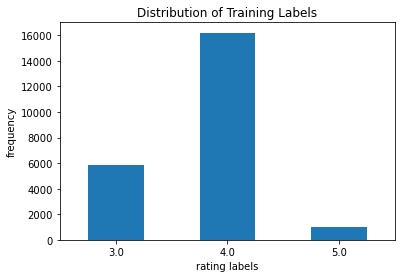

In [8]:
train_data["rating_label"].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='frequency')
plt.xlabel('rating labels')
plt.title('Distribution of Training Labels')
plt.show()

Now, we can plot the word frequency distribution for the corpus to determine the number of best features to include for our CountVectorizer files. 

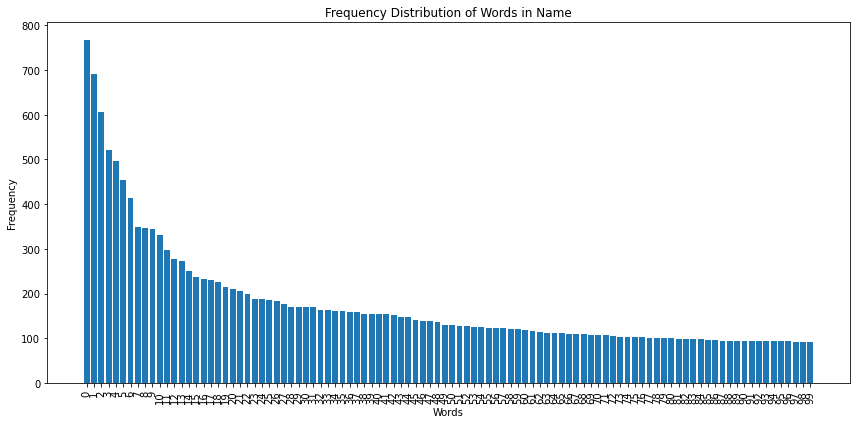

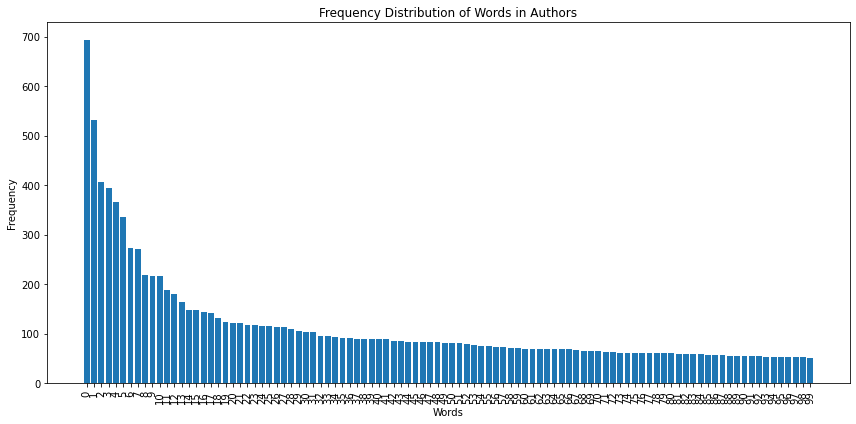

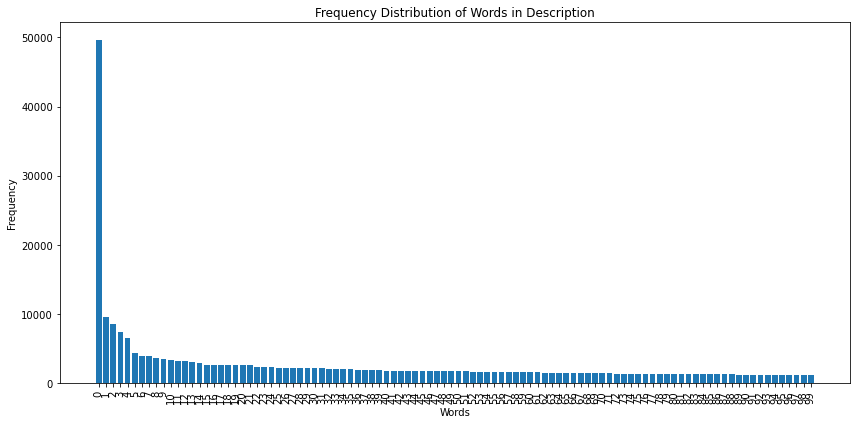

In [9]:
titles = ["Name", "Authors", "Description"]
cvs_train = [train_name_vec, train_authors_vec, train_desc_vec]

for i in range(3):
    word_freq = np.array(cvs_train[i].sum(axis=0)).flatten()

    # Sort the words and their frequencies in descending order
    sorted_indices = np.argsort(word_freq)[::-1]
    sorted_freq = word_freq[sorted_indices]

    # Set the number of words to display in the graph
    num_words = 100

    # Plot the frequency distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_words), sorted_freq[:num_words])
    plt.xticks(range(num_words), rotation=90)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f"Frequency Distribution of Words in {titles[i]}")
    plt.tight_layout()
    plt.show()
    

# 2. Data Preprocessing

Ratings are stored as floating point, since they can only 3 values and are ordinal, we can use ordinal encoding.

In [10]:
x_train_df = train_data.iloc[:, :-1] # all the columns except the last one
y_train_df = train_data.iloc[:, -1] # the last column

x_test_df = test_data.copy()

rating_to_ordinal = {3.0: 0, 4.0: 1, 5.0: 2}
ordinal_to_rating = {0: 3.0, 1: 4.0, 2: 5.0}

y_train_df_enc = y_train_df.copy().map(rating_to_ordinal)

Drop publisher and language column due to large number of missing values. We can also drop the name, authors, and description columns as we have this data represented in CountVectorizer form. 

In [11]:
columns_to_drop = ["Name", "Authors", "Publisher", "Language", "Description"]

x_train_df.drop(columns_to_drop, axis=1, inplace=True)
x_test_df.drop(columns_to_drop, axis=1, inplace=True)

x_train_df.head()

,PublishYear,PublishMonth,PublishDay,pagesNumber
0,2005,6,1,48
1,1991,10,1,364
2,2005,3,31,32
3,2004,9,1,293
4,2005,7,7,352


We can see that the frequency distribution of tokens in the corpus is pretty evenly spread for the corpus in authors and names. To ensure the performance of the model, we want to reduce the dimmensionality. 

In [12]:
# To iterate over the CountVectorizer data
cvs_test = [test_name_vec, test_authors_vec, test_desc_vec]
feat_to_word_dict = [name_feat_to_word, authors_feat_to_word, desc_feat_to_word]

# To concatenate data into one data frame
train_dfs = [x_train_df]
test_dfs = [x_test_df]

for i in range(3):
    mi = SelectKBest(mutual_info_classif, k=1000)
    train_mi = mi.fit_transform(cvs_train[i], y_train_df_enc)
    test_mi = mi.transform(cvs_test[i])
    
    col_names = []

    print(f"Most relevant {titles[i]} features (mutual information):")
    for feat_num in mi.get_support(indices=True):
        print(f"\t{feat_to_word_dict[i][feat_num]}")
        col_names.append(f"{feat_to_word_dict[i][feat_num]}_{titles[i]}_freq")

    selected_train_features = cvs_train[i].toarray()[:, mi.get_support(indices=True).tolist()]
    selected_train_df = pd.DataFrame(selected_train_features, columns=col_names)
    train_dfs.append(selected_train_df)

    selected_test_features = cvs_test[i].toarray()[:, mi.get_support(indices=True).tolist()]
    selected_test_df = pd.DataFrame(selected_test_features, columns=col_names)
    test_dfs.append(selected_test_df)

X_train_df = pd.concat(train_dfs, axis=1)
X_test_df = pd.concat(test_dfs, axis=1)

Most relevant Name features (mutual information):
	10
	11
	12
	14
	15
	1600
	1847
	1887
	1893
	1896
	1913
	1916
	1939
	1940
	1941
	1960
	1976
	2004
	24
	277
	30
	90
	able
	accessory
	according
	acts
	adam
	advice
	affair
	african
	al
	alchemy
	alcohol
	alma
	almanac
	alphabet
	america
	american
	anarchy
	anatomy
	anglo
	animal
	anniversary
	annotated
	anorexia
	anxiety
	apocalypse
	apostolate
	appalachian
	appalachians
	application
	arabic
	archaeology
	architect
	archives
	ark
	arrival
	art
	arthritis
	asian
	ask
	aspects
	asterix
	astrology
	atlas
	audio
	audubon
	baby
	bachelor
	bad
	badge
	bake
	bargain
	basement
	basements
	batman
	bears
	beginnings
	behavioral
	belief
	beloved
	beni
	benjamin
	beowulf
	berenstain
	berlin
	betray
	bible
	biblia
	bibliography
	bike
	billboard
	birds
	black
	blake
	blaze
	blazing
	blood
	bodhisattva
	body
	bolitho
	book
	books
	borders
	boss
	botanical
	boy
	brain
	branding
	brave
	breed
	bride
	bridesmaid
	bright
	britain
	brown
	buddhism
	bunny
	b

Still, we select most relevant data, so we choose an upper bound of k=1000. This value can still be optimized to a smaller amount. 

In [13]:
mi = SelectKBest(mutual_info_classif, k=1000)
train_mi = mi.fit_transform(X_train_df, y_train_df_enc)
test_mi = mi.transform(X_test_df)

features = []

for feature in mi.get_support(indices=True):
    features.append(X_train_df.columns[feature])

In [14]:
X_train_unscaled = X_train_df[features]
X_test_unscaled = X_test_df[features]

Now, we can scale the data to ensure model performance. 

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.fit_transform(X_test_unscaled)

# Models

In [16]:
def format_predictions(y_pred_enc):
    # Create a DataFrame in line with Kaggle submissions
    y_pred = pd.DataFrame({'id': range(1, len(y_pred_enc) + 1),
                               'rating_label': y_pred_enc})

    y_pred['rating_label'] = y_pred['rating_label'].map(ordinal_to_rating)

    return y_pred

## 0R (Baseline)

In [17]:
def zero_r(X_train, y_train_df_enc, X_test):
    # Create the Zero-R model
    zero_r_model = DummyClassifier(strategy="most_frequent")

    # Fit the model on the training data
    zero_r_model.fit(X_train, y_train_df_enc)

    # Predict the class labels for the test set
    y_pred0r_enc = zero_r_model.predict(X_test)

    return y_pred0r_enc

In [18]:
y_pred_enc = zero_r(X_train, y_train_df_enc, X_test)
format_predictions(y_pred_enc).to_csv(f'{PREDFILEPATH}0r.csv', index=False)

## Random Forest Classifier

Now we can fine tune our hyperparameter for selecting the appropriate number of features for all of our features. To find this, we can perform 5-fold cross validation for different values of k for feature selection.

In [19]:
# Inspired by code from tutorial 9

def optimiseK_cv(X_train, y_train_df_enc, model, model_name, k_vals):
    '''Performs feature selection optimization using different values of K and k-fold cross-validation'''

    for k in k_vals:
        print('\n--------------------------------------- K =', k, '------------------------------')
        mi = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_mi = mi.fit_transform(X_train, y_train_df_enc)

        print('\n=========', model_name, '(with k =', k, 'features): ')
        cv_scores = cross_val_score(model, X_train_mi, y_train_df_enc, cv=5)
        print('Average cross-validation accuracy:', cv_scores.mean())

To fine tune hyperparameters for feature selection. 

In [20]:
optimiseK_cv(X_train, y_train_df_enc, RandomForestClassifier(), "Random Forest Classifier", [10,100,1000])


--------------------------------------- K = 10 ------------------------------

========= Random Forest Classifier (with k = 10 features): 
Average cross-validation accuracy: 0.6885921494535692

--------------------------------------- K = 100 ------------------------------

========= Random Forest Classifier (with k = 100 features): 
Average cross-validation accuracy: 0.6441050114979181

--------------------------------------- K = 1000 ------------------------------

========= Random Forest Classifier (with k = 1000 features): 
Average cross-validation accuracy: 0.7079735067512549


We see that the random forest classifier works best when features included are 1000, so we do not perform feature selection for the random forest classifier. We can now tune the hyperparameter n_estimators. 

n_estimators = 10: Cross-validation score = 0.6736330394005101
n_estimators = 50: Cross-validation score = 0.7053285531725362
n_estimators = 100: Cross-validation score = 0.707756812688001
n_estimators = 200: Cross-validation score = 0.708840724834168
n_estimators = 500: Cross-validation score = 0.7092743761784872
n_estimators = 700: Cross-validation score = 0.7104016158565417
n_estimators = 1000: Cross-validation score = 0.7102716238602433


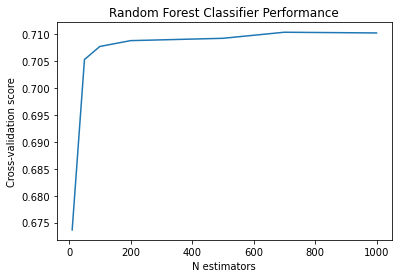

In [21]:
# Define the range of values for n_estimators to explore
n_estimators_values = [10, 50, 100, 200, 500, 700, 1000]

cv_scores = [] # To store cross-validation scores

# Perform k-fold cross-validation for each value of n_estimators
for n_estimator in n_estimators_values:
    # Create a Random Forest classifier with the current value of n_estimators
    model = RandomForestClassifier(n_estimators=n_estimator)

    # Perform k-fold cross-validation
    scores = cross_val_score(model, X_train, y_train_df_enc, cv=5)

    # Store average cross-validation score
    cv_scores.append(scores.mean())

    # Print the cross-validation score
    print(f"n_estimators = {n_estimator}: Cross-validation score = {np.mean(scores)}")

plt.plot(n_estimators_values, cv_scores)
plt.xlabel("N estimators")
plt.ylabel("Cross-validation score")
plt.title("Random Forest Classifier Performance")
plt.show()

In [22]:
def rfc(X_train, y_train_df_enc, X_test):

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=1000)

    # Train the classifier
    rf_classifier.fit(X_train, y_train_df_enc)

    # Make predictions on the test set
    y_pred_enc = rf_classifier.predict(X_test)

    return y_pred_enc

In [23]:
y_pred_enc = rfc(X_train, y_train_df_enc, X_test)
format_predictions(y_pred_enc).to_csv(f'{PREDFILEPATH}randomfrst.csv', index=False)

## K Nearest Neighbour

Finding the best number of features to include:

In [24]:
optimiseK_cv(X_train, y_train_df_enc, KNeighborsClassifier(), "K Nearest Neighbors", [10, 100, 1000])


--------------------------------------- K = 10 ------------------------------

========= K Nearest Neighbors (with k = 10 features): 
Average cross-validation accuracy: 0.6394659291804958

--------------------------------------- K = 100 ------------------------------

========= K Nearest Neighbors (with k = 100 features): 
Average cross-validation accuracy: 0.6551186651698347

--------------------------------------- K = 1000 ------------------------------

========= K Nearest Neighbors (with k = 1000 features): 
Average cross-validation accuracy: 0.6693405679375513


We can now use this information to find the best K neighbours. 

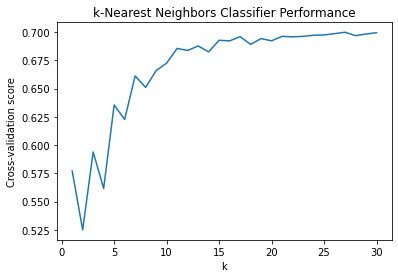

In [25]:
mi = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_knn = mi.fit_transform(X_train, y_train_df_enc)

# Define the range of values for k to explore
k_values = range(1, 31)

# Create empty lists to store the average cross-validation scores for each value of k
cv_scores = []

# Perform k-fold cross-validation for each value of k
for k in k_values:
    # Create a K-nearest neighbors classifier with the current value of k
    model = KNeighborsClassifier(n_neighbors=k)

    # Perform k-fold cross-validation
    scores = cross_val_score(model, X_train_knn, y_train_df_enc, cv=5)

    # Compute the average cross-validation score
    cv_scores.append(scores.mean())

# Plot the graph of k versus cross-validation scores
plt.plot(k_values, cv_scores)
plt.xlabel('k')
plt.ylabel('Cross-validation score')
plt.title('k-Nearest Neighbors Classifier Performance')
plt.show()

Now that we have the best K Neighbours (19), we can again optimise our feature selection using low dimmensional values. 

In [26]:
optimiseK_cv(X_train, y_train_df_enc, KNeighborsClassifier(n_neighbors=19), "19 Nearest Neighbors", [3, 5, 8, 10, 13])


--------------------------------------- K = 3 ------------------------------

========= 19 Nearest Neighbors (with k = 3 features): 
Average cross-validation accuracy: 0.6934482924590541

--------------------------------------- K = 5 ------------------------------

========= 19 Nearest Neighbors (with k = 5 features): 
Average cross-validation accuracy: 0.6937520270121639

--------------------------------------- K = 8 ------------------------------

========= 19 Nearest Neighbors (with k = 8 features): 
Average cross-validation accuracy: 0.6940552915334675

--------------------------------------- K = 10 ------------------------------

========= 19 Nearest Neighbors (with k = 10 features): 
Average cross-validation accuracy: 0.6970470721812804

--------------------------------------- K = 13 ------------------------------

========= 19 Nearest Neighbors (with k = 13 features): 
Average cross-validation accuracy: 0.6911501377475211


K=5 and K=10 both seem to do fairly well. In the interest of preserving enough information, it has been decided to do k=10. 

In [27]:
def knn(X_train, y_train_df_enc, X_test):
    # To decide 10 best features
    mi_10ft = SelectKBest(score_func=mutual_info_classif, k=10)

    # Transforming data
    X_train_knn_10ft = mi_10ft.fit_transform(X_train, y_train_df_enc)
    X_test_knn_10ft = mi_10ft.transform(X_test)

    # Creating model
    model_20NN_10ft = KNeighborsClassifier(n_neighbors=19)
    model_20NN_10ft.fit(X_train_knn_10ft, y_train_df_enc)
    y_pred_enc = model_20NN_10ft.predict(X_test_knn_10ft)

    return y_pred_enc

In [28]:
y_pred_enc = knn(X_train, y_train_df_enc, X_test)
format_predictions(y_pred_enc).to_csv(f'{PREDFILEPATH}knn.csv', index=False)

## Logistic Regression

In [29]:
# Create a Logistic Regression classifier
log_reg = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=400)

# Find best feature selection
optimiseK_cv(X_train, y_train_df_enc, log_reg, "Logistic Regression", [10, 100, 1000])


--------------------------------------- K = 10 ------------------------------

========= Logistic Regression (with k = 10 features): 
Average cross-validation accuracy: 0.7029007636888773

--------------------------------------- K = 100 ------------------------------

========= Logistic Regression (with k = 100 features): 
Average cross-validation accuracy: 0.7076703080344041

--------------------------------------- K = 1000 ------------------------------

========= Logistic Regression (with k = 1000 features): 
Average cross-validation accuracy: 0.726141420537645


1000 features performs the best, so we move to predicting test data.

In [30]:
def log_reg(X_train, y_train_df_enc, X_test):
    # Create a Random Forest classifier
    log_reg = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=400)

    # Train the classifier
    log_reg.fit(X_train, y_train_df_enc)

    # Make predictions on the test set
    y_pred_enc = log_reg.predict(X_test)

    return y_pred_enc

In [31]:
y_pred_enc = log_reg(X_train, y_train_df_enc, X_test)
format_predictions(y_pred_enc).to_csv(f'{PREDFILEPATH}logreg.csv', index=False)

# Model Performance

=============== Zero R model ==============


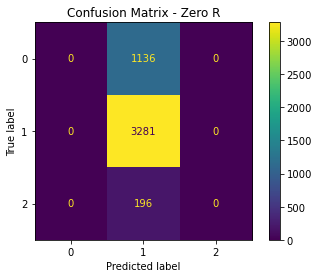

Accuracy: 0.7112508129200087
Precision: 0.23708360430666955
Recall: 0.3333333333333333
F1: 0.277088083776708
Mean Squared Error: 0.2887491870799913
=============== Random Forest model ==============


/Users/holst78631/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


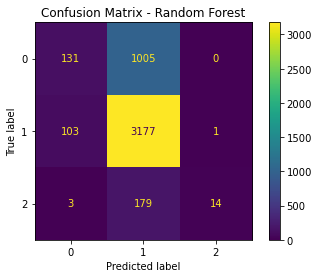

Accuracy: 0.7201387383481466
Precision: 0.7381928621256497
Recall: 0.3850159398941653
F1: 0.38499405689117333
Mean Squared Error: 0.2818122696726642
=============== KNN model ==============


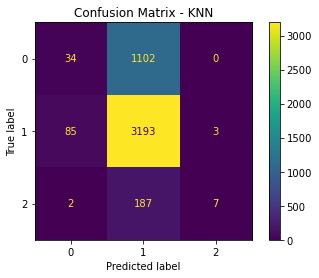

Accuracy: 0.701062215477997
Precision: 0.5644656372659294
Recall: 0.34627425734944056
F1: 0.31489278087314787
Mean Squared Error: 0.3002384565358769
=============== Logistic Regression model ==============


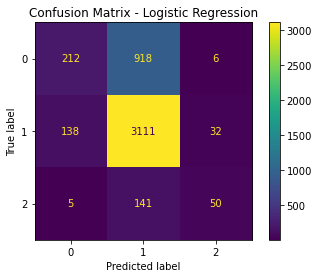

Accuracy: 0.7311944504660741
Precision: 0.6371360274136645
Recall: 0.46330276254119834
F1: 0.49051375912313383
Mean Squared Error: 0.27595924561023194


In [32]:
# Split training data to perform model evaluation
x_train_eval, x_test_eval, y_train_eval, y_test_eval = train_test_split(X_train, y_train_df_enc, test_size=0.2, random_state=42)

y_pred_0r = zero_r(x_train_eval, y_train_eval, x_test_eval)
y_pred_rfc = rfc(x_train_eval, y_train_eval, x_test_eval)
y_pred_knn = knn(x_train_eval, y_train_eval, x_test_eval)
y_pred_lr = log_reg(x_train_eval, y_train_eval, x_test_eval)

model_predictions = [y_pred_0r, y_pred_rfc, y_pred_knn, y_pred_lr]
model_titles = ["Zero R", "Random Forest", "KNN", "Logistic Regression"]

for prediction, title in zip(model_predictions, model_titles):
    print(f"=============== {title} model ==============")
    
    cm = metrics.confusion_matrix(y_test_eval, prediction)
    cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    print("Accuracy:", metrics.accuracy_score(y_test_eval, prediction))
    print("Precision:", metrics.precision_score(y_test_eval, prediction, average='macro'))
    print("Recall:", metrics.recall_score(y_test_eval, prediction, average='macro'))
    print("F1:", metrics.f1_score(y_test_eval, prediction, average='macro'))
    print("Mean Squared Error:", metrics.mean_squared_error(y_test_eval, prediction))